# Scaled Dot-Product Attention

The 2017 paper [Attention Is All You Need](https://arxiv.org/abs/1706.03762) introduced the Transformer model and scaled dot-product attention, sometimes also called QKV (**Q**ueries, **K**eys, **V**alues) attention. Since then, Transformers have come to dominate large-scale natural language applications. Scaled dot-product attention can be used to improve seq2seq models as well. In this ungraded lab, you'll implement a simplified version of scaled dot-product attention and replicate word alignment between English and French, as shown in [Bhadanau, et al. (2014)](https://arxiv.org/abs/1409.0473).

The Transformer model learns how to align words in different languages. You won't be training any weights here, so instead I've prepared some [pre-trained aligned word embeddings from here](https://fasttext.cc/docs/en/aligned-vectors.html). Run the cell below to load the embeddings and set up the rest of the notebook.

### Load word2int dictionaries and word embedding for English and French words

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Load the word2int dictionaries
with open("./data/word2int_en.pkl", "rb") as f:
    en_words = pickle.load(f)
    
with open("./data/word2int_fr.pkl", "rb") as f:
    fr_words = pickle.load(f)

# Load the word embeddings
en_embeddings = np.load("./data/embeddings_en.npz")["embeddings"]
fr_embeddings = np.load("./data/embeddings_fr.npz")["embeddings"]

The next two code snippet consists of two Python functions: `tokenize` and `embed`, which are commonly used in natural language processing (NLP). These functions help convert human-readable text into a form that can be interpreted by machine learning models. Here's a breakdown:

### Function 1: `tokenize`


In [2]:
def tokenize(sentence, token_mapping):
    tokenized = []
    
    for word in sentence.lower().split(" "):
        try:
            tokenized.append(token_mapping[word])
        except KeyError:
            # Using -1 to indicate an unknown word
            tokenized.append(-1)
        
    return tokenized

#### Explanation:
- **Input**:
    - `sentence`: A string containing the text to be tokenized.
    - `token_mapping`: A word2int dictionary where keys are words and values are their corresponding integer tokens.
  
- **Process**:
    - The function initializes an empty list, `tokenized`.
    - It then iterates over each word in the input `sentence`, converting it to lowercase and splitting it into words based on spaces.
    - For each word, it tries to find its corresponding token using `token_mapping` (word2int). If the word exists in `token_mapping`, its token is added to the `tokenized` list.
    - If a `KeyError` is encountered (the word is not in `token_mapping`), it adds `-1` to `tokenized` to indicate an unknown word.
    
- **Output**:
    - Returns `tokenized`: A list of integers representing the tokenized form of the input sentence.


### Function 2: `embed`

In [3]:
def embed(tokens, embeddings):
    embed_size = embeddings.shape[1]
    
    output = np.zeros((len(tokens), embed_size))
    for i, token in enumerate(tokens):
        if token == -1:
            output[i] = np.zeros((1, embed_size))
        else:
            output[i] = embeddings[token]
            
    return output

#### Explanation:
- **Input**:
    - `tokens`: A list of integers obtained from the `tokenize` function, representing the tokenized form of a sentence.
    - `embeddings`: A 2D NumPy array where each row corresponds to a word's embedding vector.
    
- **Process**:
    - `embed_size` stores the size of the embedding vectors, which is the number of columns in the `embeddings` matrix.
    - `output` is initialized as a 2D zero matrix with a shape of `(len(tokens), embed_size)`.
    - The function iterates over each token in `tokens`:
        - If a token is `-1` (unknown word), it assigns a zero vector to the corresponding row in `output`.
        - Otherwise, it assigns the embedding vector from `embeddings` corresponding to the token.
        
- **Output**:
    - Returns `output`: A 2D array where each row represents the embedding vector of a corresponding token in the input sentence.

### Note:
- Tokenization and embedding are fundamental steps in preparing textual data for machine learning models in NLP, converting human-readable text into numerical vectors that models can learn from.
- Handling unknown words (like with `-1` and zero-vectors) is a typical challenge in NLP, and there are various strategies to manage them based on the application.

The scaled-dot product attention consists of two matrix multiplications and a softmax scaling as shown in the diagram below from [Vaswani, et al. (2017)](https://arxiv.org/abs/1706.03762). It takes three input matrices, the queries, keys, and values.

![scaled-dot product attention diagram](./images/attention.png)

Mathematically, this is expressed as

$$ 
\large \mathrm{Attention}\left(Q, K, V\right) = \mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V
$$

where $Q$, $K$, and $V$ are the queries, keys, and values matrices respectively, and $d_k$ is the dimension of the keys. In practice, Q, K, and V all have the same dimensions. This form of attention is faster and more space-efficient than what you implemented before since it consists of only matrix multiplications instead of a learned feed-forward layer.

Conceptually, the first matrix multiplication is a measure of the similarity between the queries and the keys. This is transformed into weights using the softmax function. These weights are then applied to the values with the second matrix multiplication resulting in output attention vectors. Typically, decoder states are used as the queries while encoder states are the keys and values.

### Exercise 1
Implement the softmax function with Numpy and use it to calculate the weights from the queries and keys. Assume the queries and keys are 2D arrays (matrices). Note that since the dot-product of Q and K will be a matrix, you'll need to take care to calculate softmax over a specific axis.

### `softmax` Funtion

In [4]:
def softmax(x, axis=0):    
    """ Calculate softmax function for an array x

        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    # subtract the max for numerical stability
    x = x - np.expand_dims(np.max(x, axis=axis), axis)
    # calculate the softmax
    return np.exp(x)/np.sum(np.exp(x), axis=axis, keepdims=True)

## Explanation

The code snippet provided is a Python function implementing the **Softmax function**, a fundamental concept frequently utilized in machine learning, particularly in classification problems.

### Overview of Softmax Function

The **Softmax function** is utilized to convert a vector of raw scores (or "logits") into probabilities. Given an input vector `[z_1, z_2, ..., z_n]`, the Softmax function, %\sigma%, outputs a vector `[p_1, p_2, ..., p_n]` where each `p_i` is defined as:

$$p_i = \frac{e^{z_i}}{\sum_{j=1}^{n} e^{z_j}}$$

### Key Characteristics of the Function

#### 1. **Numerical Stability**
   
In the implementation, the maximum value along the specified axis is subtracted from each element before applying the exponential function. This is a common practice to enhance numerical stability and prevent potential overflow/underflow issues.

```python
x = x - np.expand_dims(np.max(x, axis=axis), axis)
```

#### 2. **Flexibility with Axis**

The function is designed to calculate the Softmax across different axes (`axis=0` for columns, and `axis=1` for rows), providing flexibility depending on the desired application.

- When `axis=0`, it calculates the Softmax across columns, meaning each column's values are transformed into probabilities and all values in a column sum to 1.
- When `axis=1`, it calculates the Softmax across rows, meaning each row's values are converted into probabilities, and all values in a row sum to 1.

#### 3. **Calculation of Probabilities**

The Softmax is calculated by:
   
- Taking the exponential of each element in the input array, $e^{x_i}$.
- Dividing each element by the sum of the exponentials along the specified axis.

```python
return np.exp(x) / np.expand_dims(np.sum(np.exp(x), axis=axis), axis)
```

### Usage Example

Suppose we have a 2x3 matrix representing raw score outputs from a model, and we want to convert them into probabilities:

```python
z = np.array([[1.0, 2.0, 3.0], 
              [1.0, 2.0, 3.0]])
```

Calculating the Softmax across rows:

```python
softmax_probs = softmax(z, axis=1)
```

`softmax_probs` will be a matrix of the same shape, with each row containing probabilities derived from the respective original raw scores.

### `calculate_weights` Function

In [5]:
def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    # Calculate the dot product between the queries and keys and normalize it (as seen in the equation above)
    dot = np.matmul(queries, keys.T)/np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    
    # Replace pass with your code.
    return weights

### Explanation

The `calculate_weights` function is designed to compute the weights for scaled dot-product attention, commonly used in Transformer models.

#### Parameters:
- **queries**: A matrix representing the query vectors - $Q$.
- **keys**: A matrix representing the key vectors - $K$.

#### Steps:

1. **Dot Product Calculation**:
   - The function computes the dot product between the `queries` and the transpose of `keys` $QK^{\top}$. 
   - This dot product essentially measures the similarity between each query and key.
   - The dot product values are then divided by the square root of the dimension of the keys (`keys.shape[1]`). This normalization by the square root of the depth of the keys ($\sqrt{d_k}$) helps in stabilizing gradients, especially for large values of `d_k`. 
   $$\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$

2. **Softmax Calculation**:
   - The softmax function is applied along `axis=1`, which means it's applied to each row independently. This ensures that each row in the resulting `weights` matrix will sum up to 1.
   - The softmax function ensures that values in each row are between 0 and 1 and gives a probability distribution over the keys for each query.
   $$\mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$

3. **Assertion**:
   - An assertion checks that the sum of values in each row of the `weights` matrix is indeed 1. This ensures the correctness of the softmax operation.

4. **Return**:
   - The function returns the `weights` matrix, which holds the attention weights corresponding to the similarity between each query and key pair.


This function is a core component of the scaled dot-product attention mechanism, and these weights can be later used to weigh the values in the attention mechanism, giving more importance to certain values based on the computed weights.

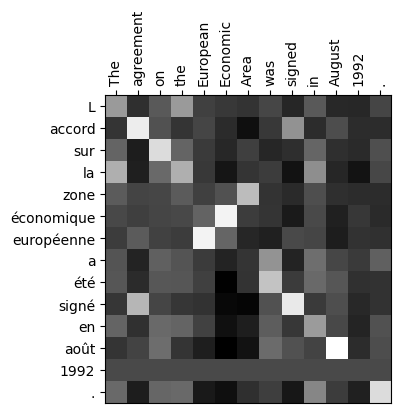

In [13]:
# Tokenize example sentences in English and French, then get their embeddings
sentence_en = "The agreement on the European Economic Area was signed in August 1992 ."
tokenized_en = tokenize(sentence_en, en_words) # tokenize English sentence using word2int dictionary
embedded_en = embed(tokenized_en, en_embeddings) # embed English sentence using word embeddings

sentence_fr = "L accord sur la zone économique européenne a été signé en août 1992 ."
tokenized_fr = tokenize(sentence_fr, fr_words) # tokenize French sentence using word2int dictionary
embedded_fr = embed(tokenized_fr, fr_embeddings) # embed French sentence using word embeddings

# These weights indicate alignment between words in English and French
alignment = calculate_weights(embedded_fr, embedded_en)

# Visualize weights to check for alignment
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(alignment, cmap='gray')
ax.xaxis.tick_top()
ax.set_xticks(np.arange(alignment.shape[1]))
ax.set_xticklabels(sentence_en.split(" "), rotation=90, size=10);
ax.set_yticks(np.arange(alignment.shape[0]));
ax.set_yticklabels(sentence_fr.split(" "), size=10);

If you implemented the weights calculations correctly, the alignment matrix should look like this:

![alignment visualization](./images/alignment.png)

This is a demonstration of alignment where the model has learned which words in English correspond to words in French. For example, the words *signed* and *signé* have a large weight because they have the same meaning. Typically, these alignments are learned using linear layers in the model, but you've used pre-trained embeddings here.

### Exercise 2
Complete the implementation of scaled dot-product attention using your `calculate_weights` function (ignore the mask).

### `attention_qkv` Function

In [9]:
def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    
    # Replace pass with your code.
    weights = calculate_weights(queries, keys)
    attention = np.dot(weights, values)
    
    return attention



### Explanation

The provided function `attention_qkv` calculates the scaled dot-product attention using the `queries` ($Q$), `keys` ($K$), and `values` ($V$) matrices.

**Function Details**:
- **Parameters**:
  - `queries`: The matrix containing query vectors - $Q$.
  - `keys`: The matrix containing key vectors - $K$.
  - `values`: The matrix containing value vectors - $V$.

**Steps**:

1. **Calculate Weights**:
    The function first calculates the attention weights using the `calculate_weights` function. This function computes the dot product of the `queries` and the transpose of the `keys` matrix, scales it by the inverse square root of the dimension of the keys, and then applies the softmax function to get the weights.
    $$\mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)$$
   
2. **Compute Attention**:
    Once the weights are obtained, the function calculates the attention output by taking the dot product of the `weights` matrix and the `values` matrix.
    $$\mathrm{softmax}\left(\frac{QK^{\top}}{\sqrt{d_k}}\right)V$$
   
   
3. **Return Attention Output**:
    The function returns the computed attention output.


The scaled dot-product attention mechanism is commonly used in Transformer architectures. The idea is to compute attention weights based on the similarity (dot product) between the queries and keys and then use these weights to form a weighted combination of values.

In [10]:

attention_qkv_result = attention_qkv(embedded_fr, embedded_en, embedded_en)

print(f"The shape of the attention_qkv function is {attention_qkv_result.shape}")
print(f"Some elements of the attention_qkv function are \n{attention_qkv_result[0:2,:10]}")

The shape of the attention_qkv function is (14, 300)
Some elements of the attention_qkv function are 
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]


**Expected output**

The shape of the attention_qkv function is `(14, 300)`

Some elements of the attention_qkv function are 
```python
[[-0.04039161 -0.00275749  0.00389873  0.04842744 -0.02472726  0.01435613
  -0.00370253 -0.0619686  -0.00206159  0.01615228]
 [-0.04083253 -0.00245985  0.00409068  0.04830341 -0.02479128  0.01447497
  -0.00355203 -0.06196036 -0.00241327  0.01582606]]
```

## Oficial Lab Solutions

```python
def softmax(x, axis=0):
    """ Calculate softmax function for an array x
    
        axis=0 calculates softmax across rows which means each column sums to 1 
        axis=1 calculates softmax across columns which means each row sums to 1
    """
    y = np.exp(x) 
    return y / np.expand_dims(np.sum(y, axis=axis), axis)

def calculate_weights(queries, keys):
    """ Calculate the weights for scaled dot-product attention"""
    dot = np.matmul(queries, keys.T)/np.sqrt(keys.shape[1])
    weights = softmax(dot, axis=1)
    
    assert weights.sum(axis=1)[0] == 1, "Each row in weights must sum to 1"
    
    return weights

def attention_qkv(queries, keys, values):
    """ Calculate scaled dot-product attention from queries, keys, and values matrices """
    weights = calculate_weights(queries, keys)
    return np.matmul(weights, values)
```